# ISM6562 Final
# Crashes
## https://catalog.data.gov/dataset/crash-reporting-drivers-data


## Start Spark Session

In [1]:
from pyspark.sql import SparkSession;
from pyspark.context import SparkContext;

# warehouse_location points to the default location for managed databases and tables
from os.path import abspath
warehouse_location = abspath('spark-warehouse')

spark = SparkSession \
    . builder \
    .master("local[*]") \
    .appName("Final") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

sc =spark.sparkContext
sc.setLogLevel("ERROR") # only display errors (not warnings)

# note: If you have multiple spark sessions running (like from a previous notebook you've run), 
# this spark session webUI will be on a different port than the default (4040). One way to 
# identify this part is with the following line. If there was only one spark session running, 
# this will be 4040. If it's higher, it means there are still other spark sesssions still running.
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)



23/11/08 19:12:43 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 10.21.12.4 instead (on interface eth0)
23/11/08 19:12:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 19:12:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session WebUI Port: 4040


In [2]:
spark

## Load Crash Data

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

In [219]:
df = pd.read_csv('data/Crash_Data.csv')
df.columns = df.columns.str.replace(' ', '_')
df.head()
#data = spark.read.csv('data/Crash_Data.csv', header=True, inferSchema=True);
#data.show(5)

/tmp/ipykernel_7051/4104958132.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Crash_Data.csv')


,Report_Number,Local_Case_Number,Agency_Name,ACRS_Report_Type,Crash_Date/Time,Route_Type,Road_Name,Cross-Street_Type,Cross-Street_Name,Off-Road_Description,...,Speed_Limit,Driverless_Vehicle,Parked_Vehicle,Vehicle_Year,Vehicle_Make,Vehicle_Model,Equipment_Problems,Latitude,Longitude,Location
0,MCP3040003N,190026050,Montgomery County Police,Property Damage Crash,05/31/2019 03:00:00 PM,NaN,NaN,NaN,NaN,PARKING LOT OF 3215 SPARTAN RD,...,15,No,No,2004,HONDA,TK,UNKNOWN,39.150044,-77.063089,"(39.15004368, -77.06308884)"
1,MCP1307000K,190024786,Montgomery County Police,Property Damage Crash,05/24/2019 05:00:00 PM,NaN,NaN,NaN,NaN,PARKING LOT,...,0,No,No,0,UNK,UNK,NaN,39.199047,-77.250743,"(39.19904667, -77.25074333)"
2,MCP2846008X,230034260,Montgomery County Police,Property Damage Crash,07/17/2023 10:45:00 AM,County,SELFRIDGE RD,County,RANDOLPH RD,NaN,...,35,No,No,2003,FORD,TK,NO MISUSE,39.054588,-77.085974,"(39.05458848, -77.08597423)"
3,MCP32610017,230034668,Montgomery County Police,Property Damage Crash,07/20/2023 11:40:00 PM,Maryland (State),MUNCASTER MILL RD,County,SHADY GROVE RD,NaN,...,45,No,No,2023,TOYT,CP,NO MISUSE,39.148721,-77.147111,"(39.14872076, -77.14711061)"
4,EJ78520081,230033429,Gaithersburg Police Depar,Property Damage Crash,07/13/2023 05:40:00 PM,Municipality,PERRY PKWY,Unknown,ENT TO SHOPPING CENTER,NaN,...,25,No,No,2001,KENWORTH,TRUCK,NaN,39.149085,-77.210731,"(39.14908542, -77.21073135)"


In [220]:
df_spark = spark.createDataFrame(df)
df_spark.printSchema

<bound method DataFrame.printSchema of DataFrame[Report_Number: string, Local_Case_Number: string, Agency_Name: string, ACRS_Report_Type: string, Crash_Date/Time: string, Route_Type: string, Road_Name: string, Cross-Street_Type: string, Cross-Street_Name: string, Off-Road_Description: string, Municipality: string, Related_Non-Motorist: string, Collision_Type: string, Weather: string, Surface_Condition: string, Light: string, Traffic_Control: string, Driver_Substance_Abuse: string, Non-Motorist_Substance_Abuse: string, Person_ID: string, Driver_At_Fault: string, Injury_Severity: string, Circumstance: string, Driver_Distracted_By: string, Drivers_License_State: string, Vehicle_ID: string, Vehicle_Damage_Extent: string, Vehicle_First_Impact_Location: string, Vehicle_Second_Impact_Location: string, Vehicle_Body_Type: string, Vehicle_Movement: string, Vehicle_Continuing_Dir: string, Vehicle_Going_Dir: string, Speed_Limit: bigint, Driverless_Vehicle: string, Parked_Vehicle: string, Vehicle_Y

In [221]:
df_spark.write.mode("overwrite").saveAsTable("crashes")
spark.catalog.listTables()

[Table(name='crashes', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False)]

## Create Oversampled table

In [225]:
fatal_count = len(df[df['ACRS_Report_Type'] == 'Fatal Crash'])
nonfatal_count = len(df[df['ACRS_Report_Type'] != 'Fatal Crash'])
ratio = nonfatal_count/fatal_count
print(ratio)

374.9398496240602


In [394]:
fatal_records_df = df[df['ACRS_Report_Type'] == 'Fatal Crash']
oversampled_df = fatal_records_df.sample(frac=100, random_state=1234, replace = True)
oversampled_df = pd.concat([df,oversampled_df])


In [395]:
spark.createDataFrame(oversampled_df).write.mode("overwrite").saveAsTable("oversampled_crashes")
spark.catalog.listTables()

[Table(name='crashes', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='oversampled_crashes', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False)]

In [396]:
spark.sql("SELECT ACRS_Report_Type, count(*) FROM oversampled_crashes GROUP BY ACRS_Report_Type").show()

+--------------------+--------+
|    ACRS_Report_Type|count(1)|
+--------------------+--------+
|        Injury Crash|   36158|
|Property Damage C...|   63576|
|         Fatal Crash|   26866|
+--------------------+--------+



## Use spark Sql to query relevant  from the raw table load into a formatted dataframe with some massaging on the columns

In [523]:
data = spark.sql("SELECT Report_Number\
               , CASE WHEN ACRS_Report_Type = 'Fatal Crash' THEN 1 ELSE 0 END as Fatality\
               , Weather\
               , Surface_Condition\
               , Light\
               , CASE WHEN Driver_Substance_Abuse in ('UNKNOWN','N/A','NONE DETECTED') THEN 'NONE' ELSE Driver_Substance_Abuse END as Substance_Abuse\
               FROM oversampled_crashes")
data = data.dropna()
data.show(5)

+-------------+--------+-------+-----------------+--------------+---------------+
|Report_Number|Fatality|Weather|Surface_Condition|         Light|Substance_Abuse|
+-------------+--------+-------+-----------------+--------------+---------------+
|  MCP2354000F|       0|RAINING|              WET|DARK LIGHTS ON|           NONE|
|  MCP2891002V|       0|RAINING|              WET|      DAYLIGHT|           NONE|
|  MCP2564000B|       0|    NaN|              NaN|      DAYLIGHT|           NONE|
|   DD5650001D|       0|  CLEAR|              DRY|      DAYLIGHT|           NONE|
|  MCP9106000V|       0|   SNOW|              ICE|      DAYLIGHT|           NONE|
+-------------+--------+-------+-----------------+--------------+---------------+
only showing top 5 rows



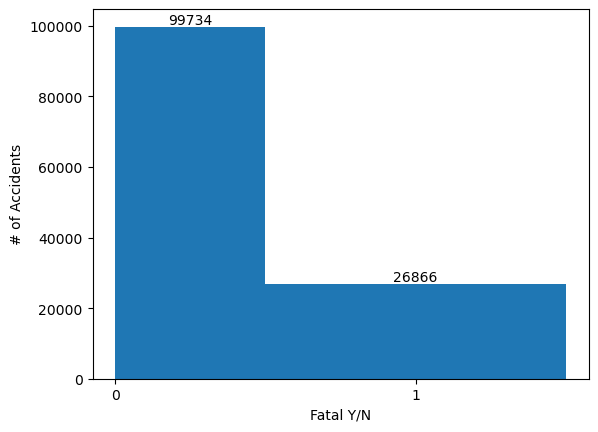

In [555]:
df2 = data.toPandas()
values, bins, bars = plt.hist(df2['Fatality'], bins=[0,0.5,1.5])
plt.xlabel("Fatal Y/N")
plt.ylabel("# of Accidents")
plt.xticks([0, 1])
plt.bar_label(bars)
plt.show()

Note: This is a skewed dataset, most crashes are not fatal, we must be careful when evaluating models

In [556]:
train_data,test_data = data.randomSplit([0.75,0.25])

## Logistic Regression

In [557]:
# Import libraries
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline

In [558]:
Weather_indexer                = StringIndexer(inputCol='Weather', outputCol='Weather_index', handleInvalid='keep')
Surface_Condition_indexer      = StringIndexer(inputCol='Surface_Condition', outputCol='Surface_Condition_index', handleInvalid='keep')
Light_indexer                  = StringIndexer(inputCol='Light', outputCol='Light_index', handleInvalid='keep')
Substance_Abuse_indexer        = StringIndexer(inputCol='Substance_Abuse', outputCol='Substance_Abuse_index', handleInvalid='keep')

In [559]:
data_encoder = OneHotEncoder(
    inputCols=[
        'Weather_index',
        'Surface_Condition_index',
        'Light_index',
        'Substance_Abuse_index'
    ],
     outputCols=[
        'Weather_vector',
        'Surface_Condition_vector',
        'Light_vector',
        'Substance_Abuse_vector'
     ],
    handleInvalid='keep'
)

In [560]:
assembler = VectorAssembler(
    inputCols=[
        'Weather_vector',
        'Surface_Condition_vector',
        'Light_vector',
        'Substance_Abuse_vector'
    ],
    outputCol = "features"
)

In [561]:
logit_model = LogisticRegression(labelCol='Fatality')

In [562]:
logit_pipe = Pipeline(
    stages=[
        Weather_indexer,
        Surface_Condition_indexer,
        Light_indexer, 
        Substance_Abuse_indexer, 
        data_encoder,
        assembler,
        logit_model
    ]
)

In [563]:
fit_model = logit_pipe.fit(train_data)
logit_results = fit_model.transform(test_data)

In [564]:
logit_results.select(['Fatality','prediction']).show()

+--------+----------+
|Fatality|prediction|
+--------+----------+
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 20 rows



## Evaluate Logistic Regression

In [565]:
nf = logit_results.filter(col("prediction")==0).count()
f = logit_results.filter(col("prediction")==1).count()

print(f"Precited Non Fatal: {nf}")
print(f"Precited Fatal: {f}")

Precited Non Fatal: 29399
Precited Fatal: 2239


In [566]:
from pyspark.ml.evaluation import RegressionEvaluator
MAE_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="Fatality", metricName="mae")
mae = MAE_evaluator.evaluate(logit_results)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.2081990012010873


In [567]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Fatality',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(logit_results)

AUPR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Fatality',metricName='areaUnderPR')
AUPR = AUPR_evaluator.evaluate(logit_results)

print(f"Area Under Curve: {AUC}")
print(f"Area Under PR Curve: {AUPR}")

Area Under Curve: 0.5711250987243278
Area Under PR Curve: 0.417648153856127


In [568]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
ACC_evaluator = MulticlassClassificationEvaluator(labelCol="Fatality",predictionCol="prediction",metricName="accuracy")
Accuracy = ACC_evaluator.evaluate(logit_results)
print(Accuracy)

0.7918009987989127


In [569]:
from sklearn.metrics import confusion_matrix

y_true = logit_results.select("Fatality").toPandas()
 
y_pred = logit_results.select("prediction").toPandas()
 
cnf_matrix = confusion_matrix(y_true, y_pred)

print(cnf_matrix)



[[23804   992]
 [ 5595  1247]]


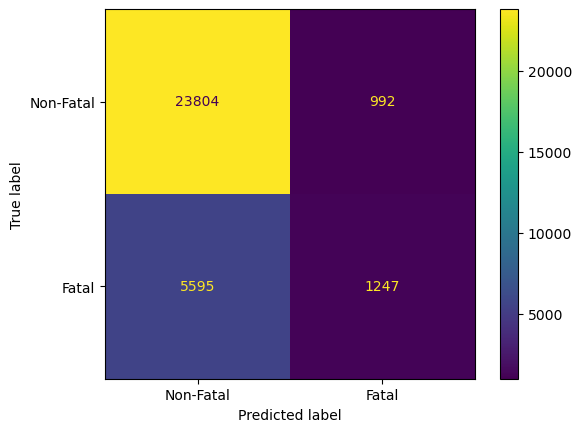

In [570]:
from sklearn.metrics import ConfusionMatrixDisplay

 
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels = ['Non-Fatal', 'Fatal'])
disp.plot()
plt.show()

In [571]:


tn = cnf_matrix[0][0]
fp = cnf_matrix[0][1]
fn = cnf_matrix[1][0]
tp = cnf_matrix[1][1]

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*(precision*recall)/(precision+recall)



print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



Accuracy: 0.79
Precision: 0.56
Recall: 0.18
F1 Score: 0.27


## SVC

In [572]:
assembler = VectorAssembler(
    inputCols=[
        'Weather_index',
        'Surface_Condition_index',
        'Light_index',
        'Substance_Abuse_index'
    ],
    outputCol = "unscaled_features"
)

In [573]:
scaler = StandardScaler(inputCol= "unscaled_features", outputCol = "features")

In [574]:
svc_model = LinearSVC(labelCol='Fatality')

In [575]:
svc_pipe = Pipeline(
    stages=[
        Weather_indexer,
        Surface_Condition_indexer,
        Light_indexer, 
        Substance_Abuse_indexer, 
        assembler,
        scaler,
        svc_model
    ]
)

In [576]:
svc_fit_model = svc_pipe.fit(train_data)

23/11/08 23:57:40 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


In [577]:
svc_results = svc_fit_model.transform(test_data)
svc_results.select(['Fatality','prediction']).show()

+--------+----------+
|Fatality|prediction|
+--------+----------+
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 20 rows



In [578]:
from pyspark.sql.functions import col
nf = svc_results.filter(col("prediction")==0).count()
f = svc_results.filter(col("prediction")==1).count()

print(f"Precited Non Fatal: {nf}")
print(f"Precited Fatal: {f}")

Precited Non Fatal: 31638
Precited Fatal: 0


In [579]:
from pyspark.ml.evaluation import RegressionEvaluator
MAE_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="Fatality", metricName="mae")
mae = MAE_evaluator.evaluate(svc_results)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.2162589291358493


In [580]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Fatality',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(svc_results)

AUPR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Fatality',metricName='areaUnderPR')
AUPR = AUPR_evaluator.evaluate(svc_results)

print(f"Area Under Curve: {AUC}")
print(f"Area Under PR Curve: {AUPR}")

Area Under Curve: 0.5
Area Under PR Curve: 0.2162589291358493


In [581]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
ACC_evaluator = MulticlassClassificationEvaluator(labelCol="Fatality",predictionCol="prediction",metricName="accuracy")
Accuracy = ACC_evaluator.evaluate(svc_results)
print(Accuracy)

0.7837410708641507


In [582]:
from sklearn.metrics import confusion_matrix

y_true = svc_results.select("Fatality").toPandas()
 
y_pred = svc_results.select("prediction").toPandas()
 
cnf_matrix = confusion_matrix(y_true, y_pred)

print(cnf_matrix)



[[24796     0]
 [ 6842     0]]


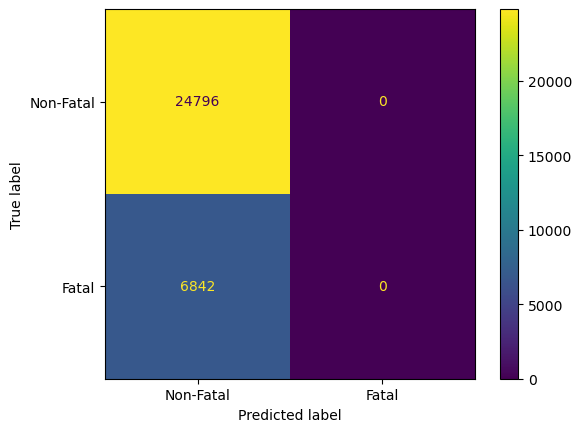

In [583]:
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels = ['Non-Fatal', 'Fatal'])
disp.plot()
plt.show()

In [584]:


tn = cnf_matrix[0][0]
fp = cnf_matrix[0][1]
fn = cnf_matrix[1][0]
tp = cnf_matrix[1][1]

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*(precision*recall)/(precision+recall)



print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



Accuracy: 0.78
Precision: nan
Recall: 0.00
F1 Score: nan


/tmp/ipykernel_7051/3986551684.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 37224)
Traceback (most recent call last):
  File "/home/student/miniconda3/envs/bd/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/student/miniconda3/envs/bd/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/home/student/miniconda3/envs/bd/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/home/student/miniconda3/envs/bd/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/home/student/miniconda3/envs/bd/lib/python3.11/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
